In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [4]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель ResNet50V2 без верхних слоев:

In [5]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(256, 256, 3),
                                              include_top=False,
                                              weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [6]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [9]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 40)             │        20,520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,634,408 (93.97 MB)

 Trainable params: 1,069,608 (4.08 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Начнем обучение модели с замороженными нижними слоями:

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [12]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/resnet_50_v2.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [13]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


I0000 00:00:1713932443.192717   78022 service.cc:145] XLA service 0x7dc808111900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713932443.192773   78022 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-24 11:20:43.349171: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 11:20:44.265367: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/433 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step - accuracy: 0.0000e+00 - loss: 4.2269   

I0000 00:00:1713932452.319479   78022 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 ━━━━━━━━━━━━━━━━━━━━ 67s 122ms/step - accuracy: 0.2179 - loss: 3.0608 - val_accuracy: 0.5442 - val_loss: 1.6396
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - accuracy: 0.5197 - loss: 1.6823 - val_accuracy: 0.6185 - val_loss: 1.3454
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.5979 - loss: 1.3965 - val_accuracy: 0.6546 - val_loss: 1.2161
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.6397 - loss: 1.2291 - val_accuracy: 0.6675 - val_loss: 1.1491
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.6784 - loss: 1.1091 - val_accuracy: 0.6941 - val_loss: 1.0831
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.7066 - loss: 1.0021 - val_accuracy: 0.7019 - val_loss: 1.0450
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.7290 - loss: 0.9254 - val_accuracy: 0.7127 - val_loss: 1.0116
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.7420 - loss: 0.8803 - val

Так как число параметров в нижних слоях огромно (более 23 миллионов), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [14]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.7486 - loss: 0.8333


In [15]:
results

[0.8771549463272095, 0.7489919066429138]

Посомтрим несколько предсказаний:

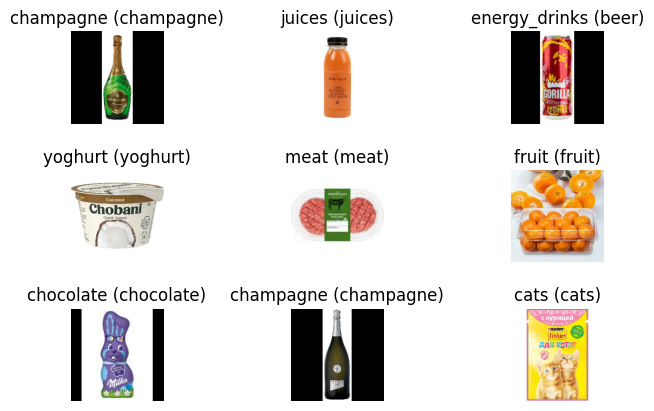

In [16]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


2024-04-24 11:36:41.650693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


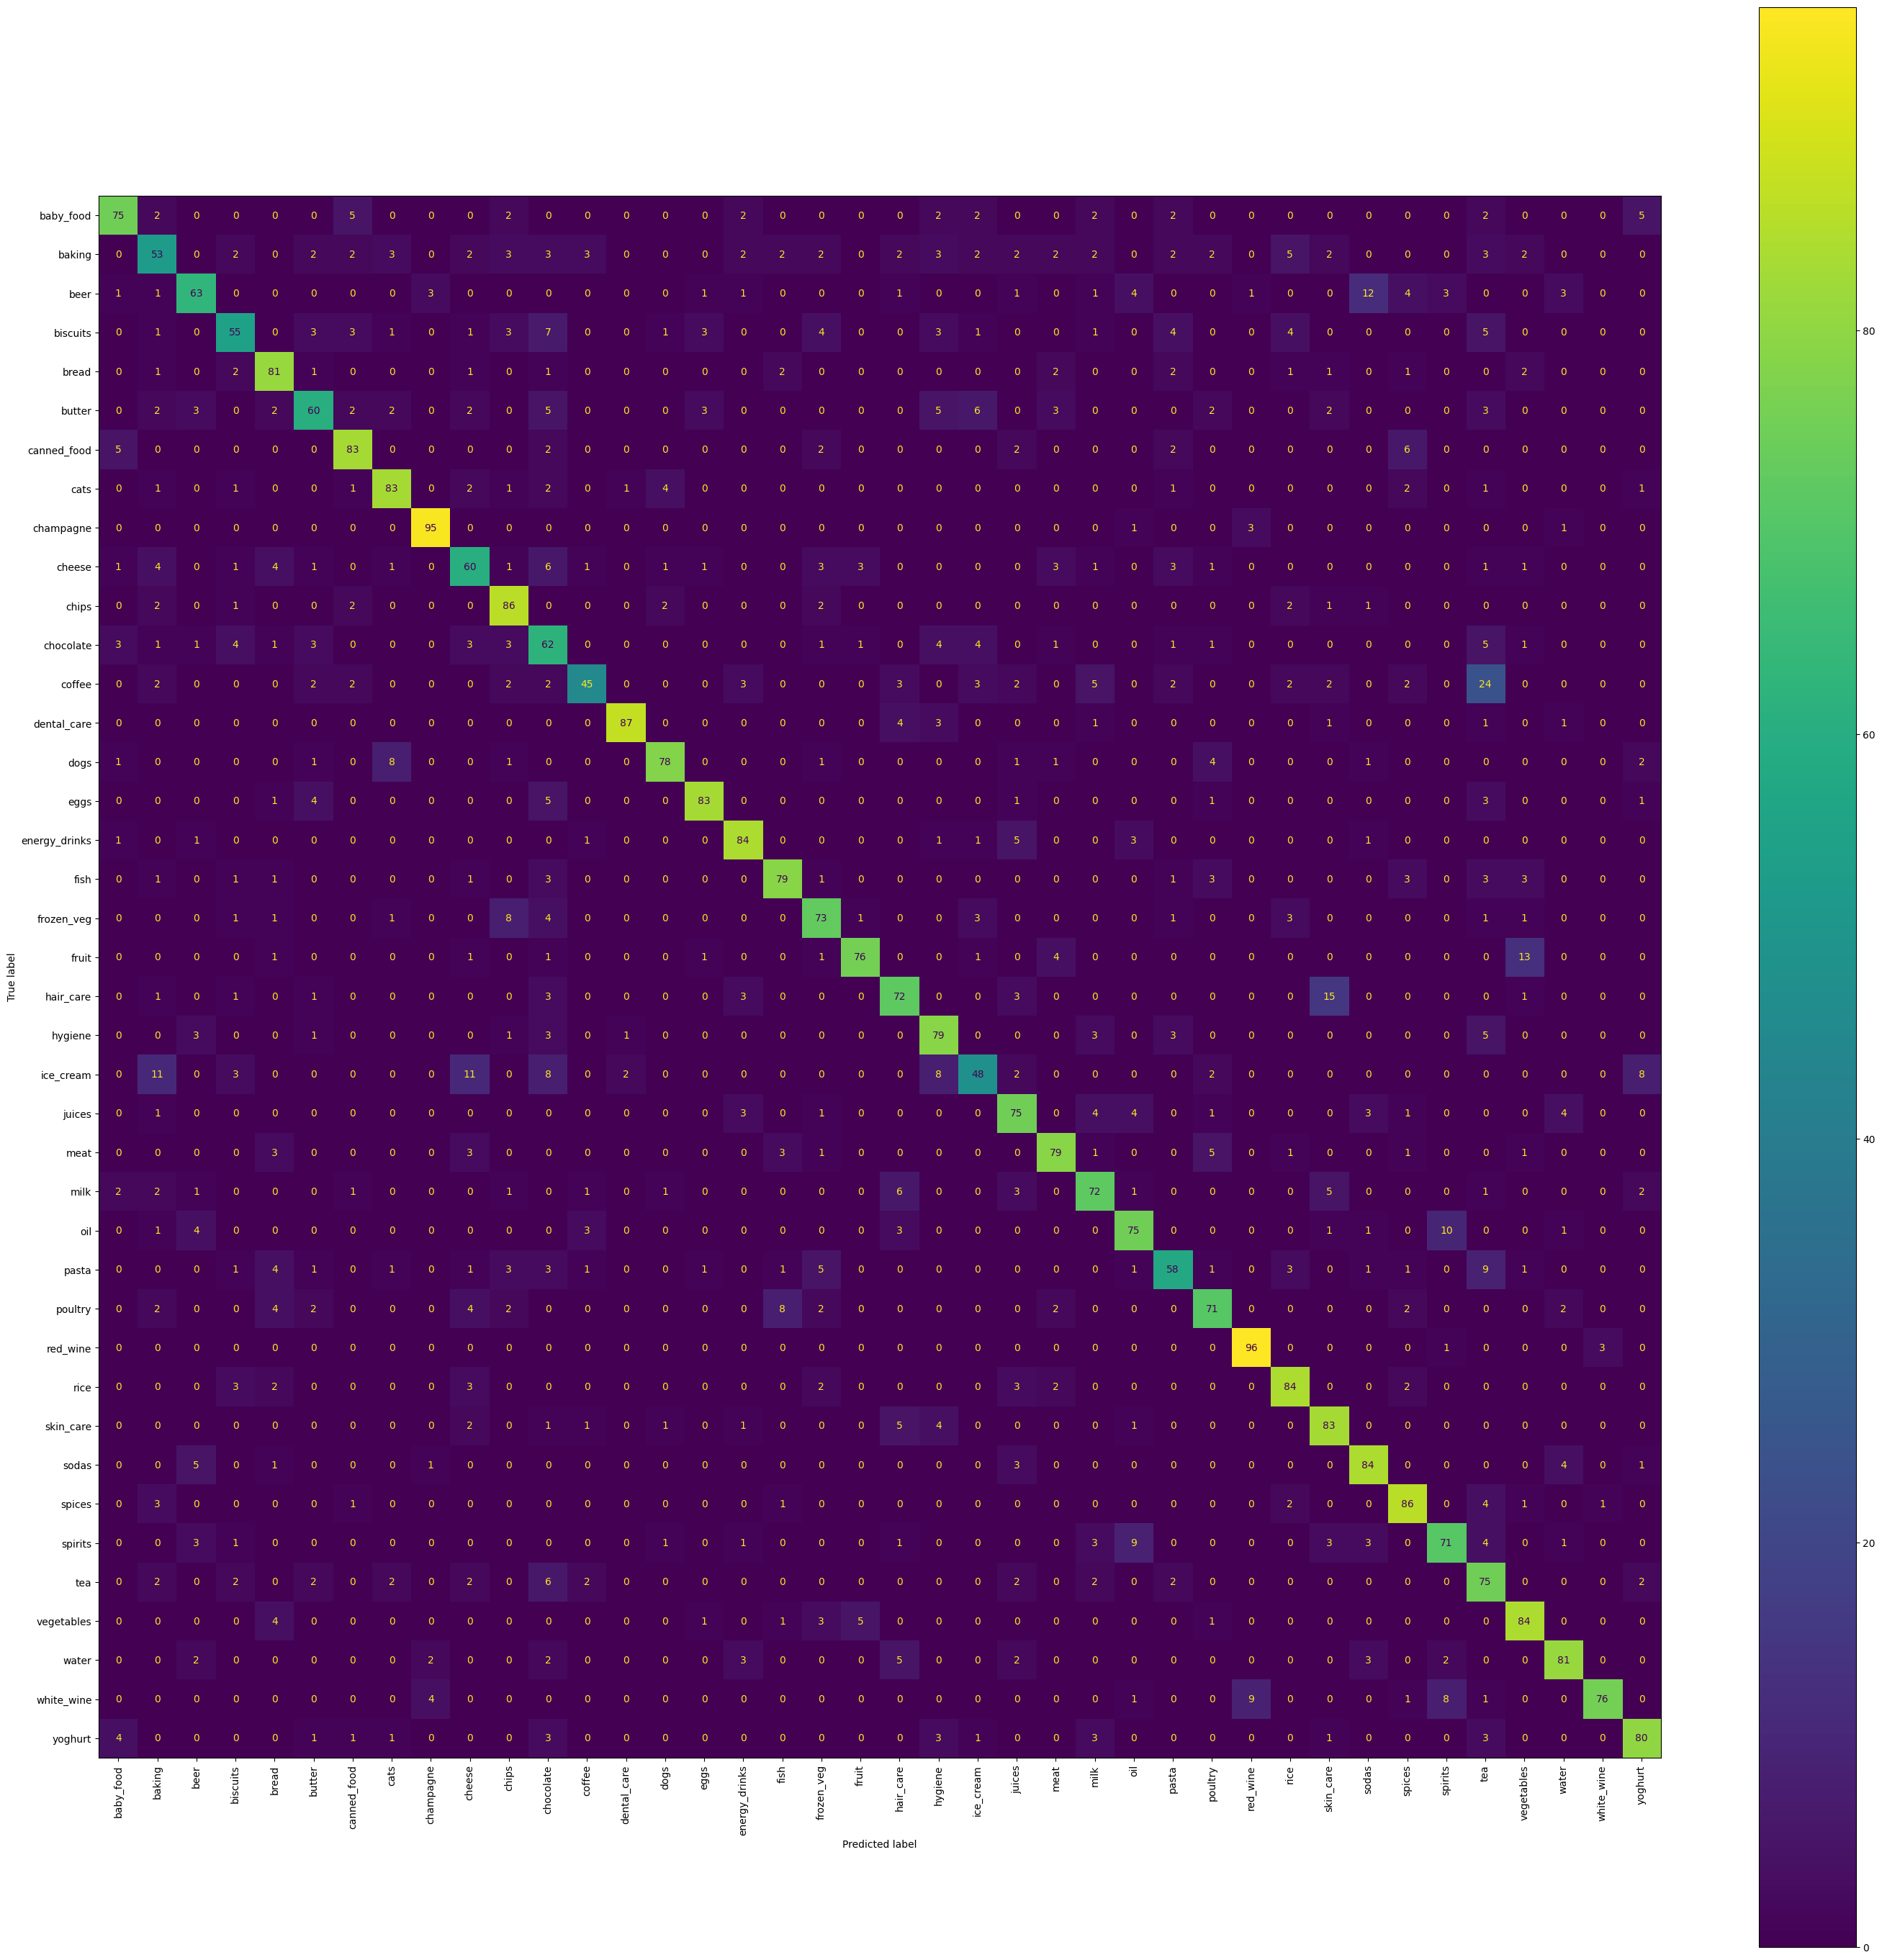

In [17]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [18]:
model.save('ready_models/resnet_50_v2.keras')

In [19]:
import json

with open('models_histories/resnet_50_v2.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

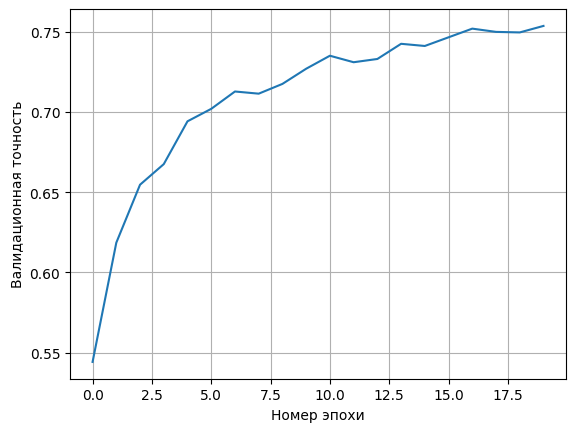

In [20]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')